In [2]:
import cv2
import numpy as np

import sys
sys.path.append("../")

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from src.pascal_voc import PascalVOCDataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def show_img(img, figsize=(10, 6), cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')

### Prepare paths to the dataset
---

In [3]:
root_dir = "/beegfs/home/d.kuznedelev/Datasets/VOCdevkit/VOC2012"

image_dir = f"{root_dir}/JPEGImages"
anno_dir  = f"{root_dir}/SegmentationClass"
knn_anno_dir = f"{root_dir}/kNNannotations"
info_path_train = f"{root_dir}/ImageSets/Segmentation/train.txt"
info_path_val = f"{root_dir}/ImageSets/Segmentation/val.txt"

### Dataset with original and kNN annotations
---

In [98]:
VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

In [99]:
class PascalVOCWithKNN:
    
    def __init__(self, root_dir, split='train', transform=None):
        self.transform = transform
        self.image_dir    = f"{root_dir}/JPEGImages"
        self.anno_dir     = f"{root_dir}/SegmentationClass"
        self.knn_anno_dir = f"{root_dir}/kNNannotations"
        
        info_path = f"{root_dir}/ImageSets/Segmentation/{split}.txt"
        self.image_names = []
        with open(info_path_train, "r") as f:
            self.image_names = [line.strip('\n') for line in f]
            

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image_name = self.image_names[index]
        # get image
        image = cv2.imread(f"{self.image_dir}/{image_name}.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # get mask
        mask = cv2.imread(f"{self.anno_dir}/{image_name}.png")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        # get knn mask
        knn_mask = np.load(f"{self.knn_anno_dir}/{image_name}.npy")
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            # apply again to get kNN mask
            transformed = self.transform(image=image, mask=knn_mask)
            knn_mask = transformed["mask"]
            
        # mask to bool
        mask = mask.astype(bool)
        # convert knn mask to the (H, W, C)
        knn_mask = np.stack([knn_mask == i for i in range(len(VOC_COLORMAP))], axis=-1)
            
        return image, mask, knn_mask

In [136]:
def get_random_colors(n_colors):
    return np.random.randint(low=0, high=256, size=(n_colors, 3))


def IoU(mask1, mask2, eps=1e-6):
    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2) - intersection
    if union == 0:
        return 0.0
    return (intersection + eps) / (union + eps)


def IoU_matrix(mask1, mask2, eps=1e-6):
    num_classes = len(VOC_COLORMAP)
    
    cost_matrix = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            cost_matrix[i, j] = IoU(mask1[..., i], mask2[... ,j])
            
    return cost_matrix

def binary_mask_to_multiclass(mask):
    mask = mask.transpose(2, 0, 1)
    multiclass_mask = np.zeros(mask.shape[1:], dtype=np.uint8)
    for i, per_class_mask in enumerate(mask):
        multiclass_mask[per_class_mask] = i
    return multiclass_mask

In [101]:
train_dataset = PascalVOCWithKNN(split='train', root_dir=root_dir)

In [171]:
image, mask, knn_mask = train_dataset[777]

### Visualize original and kNN mask
---

In [172]:
colors = get_random_colors(21)

In [173]:
mask_mc = binary_mask_to_multiclass(mask)
knn_mask_mc = binary_mask_to_multiclass(knn_mask)

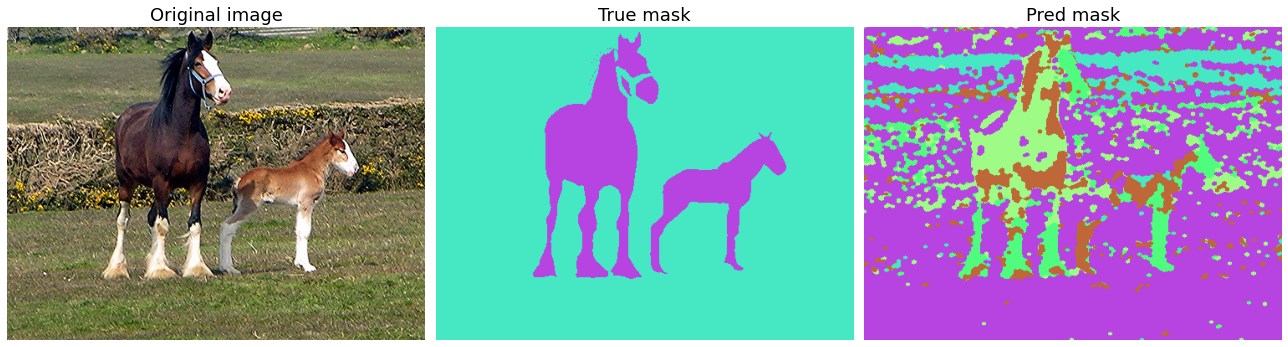

In [174]:
nrows, ncols = 1, 3
h, w = 6, 6

fig, ax = plt.subplots(nrows, ncols, figsize=(h * ncols, w * nrows))

ax[0].imshow(image)
ax[0].set_title("Original image", fontsize=18)

ax[1].imshow(colors[mask_mc])
ax[1].set_title("True mask", fontsize=18)

ax[2].imshow(colors[knn_mask_mc])
ax[2].set_title("Pred mask", fontsize=18)

for i in range(3):
    ax[i].axis('off')

plt.tight_layout()

### Compute optimal matching
---

In [182]:
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

In [183]:
mean_iou_s = []

for (image, mask, knn_mask) in tqdm(train_dataset):
    iou_matrix = IoU_matrix(mask, knn_mask)
    # compute hungarian matchin
    row_idx, col_idx = linear_sum_assignment(-iou_matrix)
    # compute opt cost
    opt_cost = iou_matrix[row_idx, col_idx].sum()
    # compute num classes in the union
    n_union_classes = ((mask.sum(axis=(0, 1)) != 0)[col_idx] | (knn_mask.sum(axis=(0, 1)) != 0)).sum()
    mean_iou = opt_cost / n_union_classes
    
    mean_iou_s.append(mean_iou)

1464it [15:39,  1.56it/s]


In [188]:
print(f"Mean IoU over the whole dataset is {sum(mean_iou_s) / len(mean_iou_s):.4f}")

Mean IoU over the whole dataset is 0.1184
